# Cleaning the dataset


Load the dataset:


In [17]:
import pandas as pd

file_path = "..../dirtydata.csv"
df = pd.read_csv(file_path, delimiter=";")

## Clean Column Names


Standardize column names:


In [18]:
df.columns = (
    df.columns.str.lower()
    .str.lstrip()
    .str.rstrip()
    .str.replace(".", "_")
    .str.replace("-", "_")
    .str.replace(" ", "_")
)

Rename specific columns:


In [19]:
df = df.rename(
    columns={
        "agegroup": "age_group",
        "health_expenditure%gdp": "health_expenditure_gdp",
        "mortality_rate_per_1000": "mortality_rate_per_thousand",
        "poverty_rate_%": "poverty_rate_percent",
    }
)

Create variables for column names to be used later:


In [20]:
categorical_column_names = [
    "age_group",
    "cause_of_death",
    "country",
    "economic_status",
    "education_level",
    "year",
]

numerical_column_names = [
    "population",
    "health_expenditure_gdp",
    "mortality_rate_per_thousand",
    "life_expectancy",
    "gdp_per_capita",
    "healthcare_access_index",
    "poverty_rate_percent",
    "environmental_pollution_index",
    "healthcare_quality_index",
]

## Use absolute values


Replace values in the `population` and `healthcare_quality_index` columns with the absolute values:


In [21]:
df[["population", "healthcare_quality_index"]] = df[
    ["population", "healthcare_quality_index"]
].abs()

## Check outliers


Convert `poverty_rate_percent` to float to prepare for the next step:


In [22]:
df["poverty_rate_percent"] = df["poverty_rate_percent"].str.rstrip("%").astype(float)

Check for outliers in the numerical columns and raise an error if any exist:


In [23]:
for column_name in numerical_column_names:
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)][
        column_name
    ]

    if not outliers.empty:
        msg = "Found outliers in column {column_name}: {outliers}"
        raise Exception(msg)

## Remove duplicates


Drop duplicates in the dataset:


In [24]:
df = df.drop_duplicates()

## Clean NA values


Remove NA values in categorical data:


In [25]:
df = df.dropna(subset=categorical_column_names)

Replace the NA values with the mean of the columns for other data:


In [26]:
df[numerical_column_names] = df[numerical_column_names].fillna(
    value=df[numerical_column_names].mean()
)

## Correct column types


Convert the `year`, `population` columns to integer:


In [27]:
df[["year", "population"]] = df[["year", "population"]].astype(int)

Check the data types and raise an error if any are incorrect:


In [29]:
expected_dtypes = {
    "year": "int64",
    "country": "object",
    "age_group": "object",
    "cause_of_death": "object",
    "economic_status": "object",
    "health_expenditure_gdp": "float64",
    "mortality_rate_per_thousand": "float64",
    "life_expectancy": "float64",
    "education_level": "object",
    "population": "int64",
    "gdp_per_capita": "float64",
    "healthcare_access_index": "float64",
    "poverty_rate_percent": "float64",
    "healthcare_quality_index": "float64",
    "environmental_pollution_index": "float64",
}

for column, expected_type in expected_dtypes.items():
    if df[column].dtype != expected_type:
        msg = (
            f"Column {column} has incorrect dtype. "
            f"Expected {expected_type}, got {df[column].dtype}"
        )

## Correct spelling errors


Clean `economic_status`, `education_level`, `cause_of_death` and `country` columns by correcting the spelling:


In [30]:
df[["economic_status", "education_level"]] = df[
    ["economic_status", "education_level"]
].replace(
    {"high": "High", "l0w": "Low", "L0w": "Low", "low": "Low", "midd1e": "Middle"}
)

df["cause_of_death"] = df["cause_of_death"].replace(
    {"Cardi0vascular": "Cardiovascular", "Infecti0us diseases": "Infectious diseases"}
)

df["country"] = df["country"].str.replace("0", "o")

## Save the cleaned data


Save to a new CSV file:


In [164]:
df.to_csv("../dataset/clean.csv", index=False)

## ABDURRAHMAN MELİH GÖKDAĞ

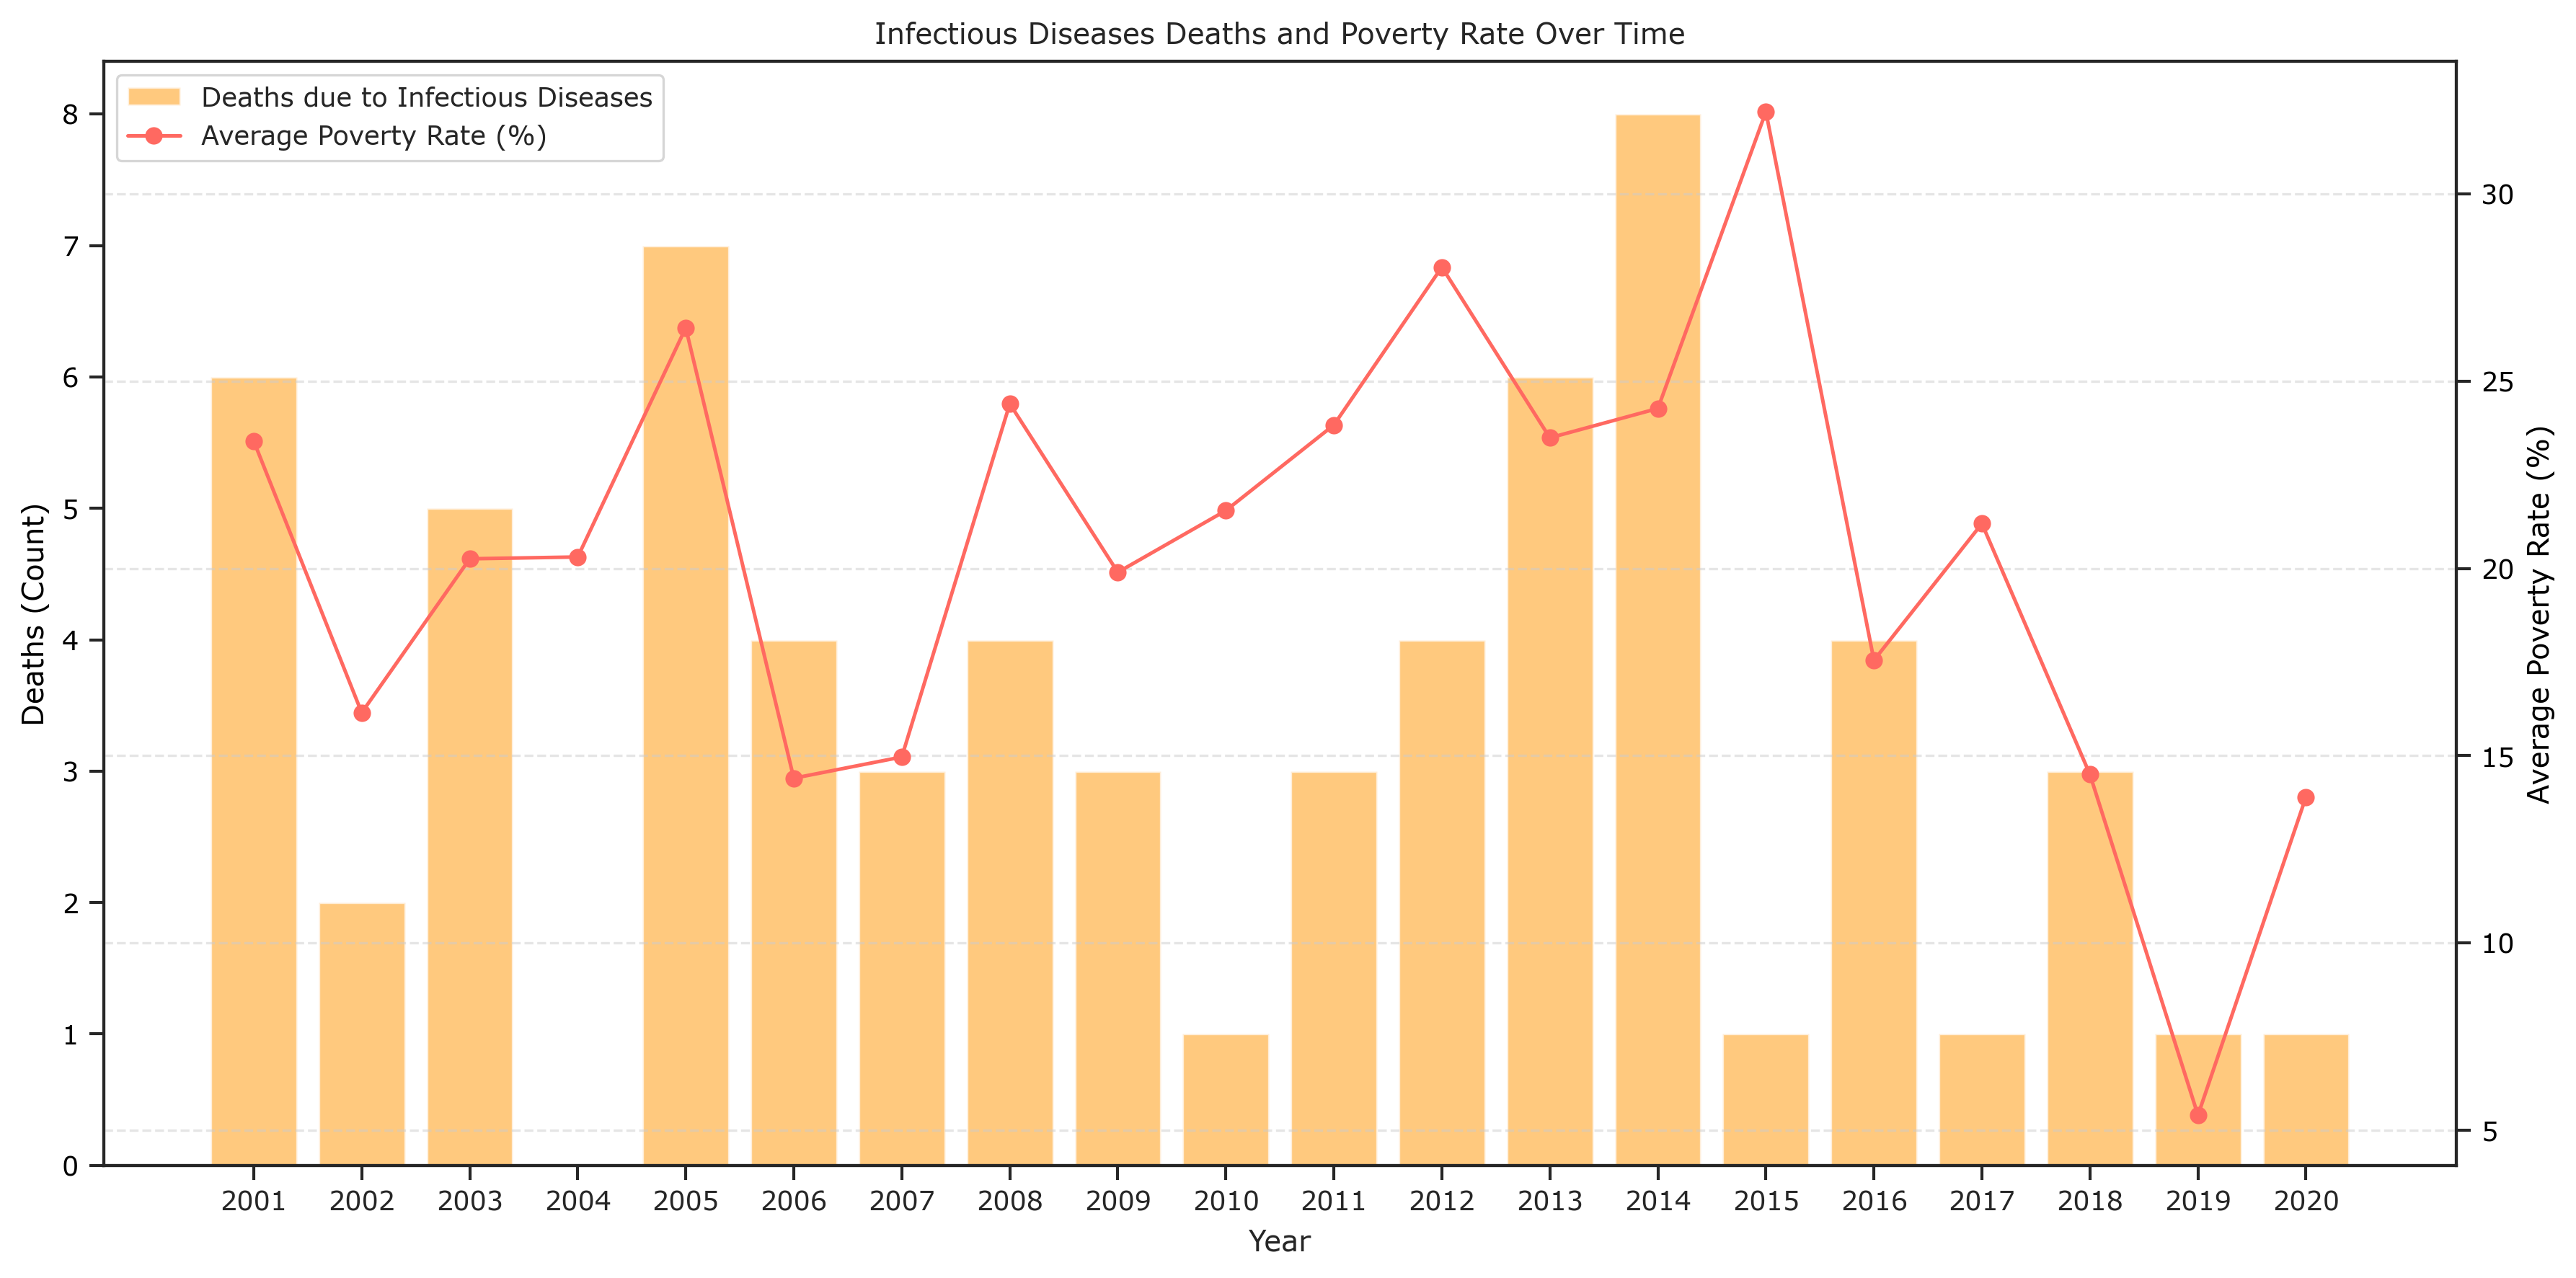

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Set seaborn theme and style
sns.set_theme(
    style="ticks",
    font="Verdana",
    palette=sns.color_palette(["#77dd77", "#ffb347", "#ff6961"]),  # Custom color palette
    context="paper",
)

mpl.rcParams["figure.dpi"] = 300  # Adjusting DPI for high resolution

# Load the cleaned dataset
file_path = '.../cleandata.csv'
df_clean = pd.read_csv(file_path)

# Converting the 'year' column to a numeric type, handling non-numeric values by replacing them with 0, and ensuring the final type is integer.
df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce').fillna(0).astype(int)

# Filtering data for 'Infectious diseases'
infectious_data = df_clean[df_clean['cause_of_death'] == 'Infectious diseases']

# Group by year and calculate death count (using the count of rows for each year)
grouped_data = infectious_data.groupby('year').agg({
    'cause_of_death': 'count',  # 'count' of rows represents the death count
    'poverty_rate_percent': 'mean'
}).reset_index()

# Renaming columns for clarity
grouped_data = grouped_data.rename(columns={'cause_of_death': 'death_count'})

# Filling the missing years
all_years = pd.DataFrame({'year': range(grouped_data['year'].min(), grouped_data['year'].max() + 1)})
grouped_data = pd.merge(all_years, grouped_data, on='year', how='left')

# Handling NaN values
grouped_data['death_count'] = grouped_data['death_count'].fillna(0).astype(int)
grouped_data['poverty_rate_percent'] = grouped_data['poverty_rate_percent'].fillna(grouped_data['poverty_rate_percent'].mean())

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for deaths due to infectious diseases with new color
ax1.bar(grouped_data['year'], grouped_data['death_count'], color=sns.color_palette(["#ffb347"])[0], alpha=0.7, label='Deaths due to Infectious Diseases')
ax1.set_xlabel('Year')
ax1.set_ylabel('Deaths (Count)', color=sns.color_palette(["black"])[0])
ax1.tick_params(axis='y', labelcolor=sns.color_palette(["black"])[0])
ax1.set_xticks(grouped_data['year'])  

# Line plot for poverty rate with new color
ax2 = ax1.twinx()
ax2.plot(grouped_data['year'], grouped_data['poverty_rate_percent'], color=sns.color_palette(["#ff6961"])[0], marker='o', label='Average Poverty Rate (%)')
ax2.set_ylabel('Average Poverty Rate (%)', color=sns.color_palette(["black"])[0])
ax2.tick_params(axis='y', labelcolor=sns.color_palette(["black"])[0])

# Adding legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Infectious Diseases Deaths and Poverty Rate Over Time')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## AHMET SAFA YONCACILAR

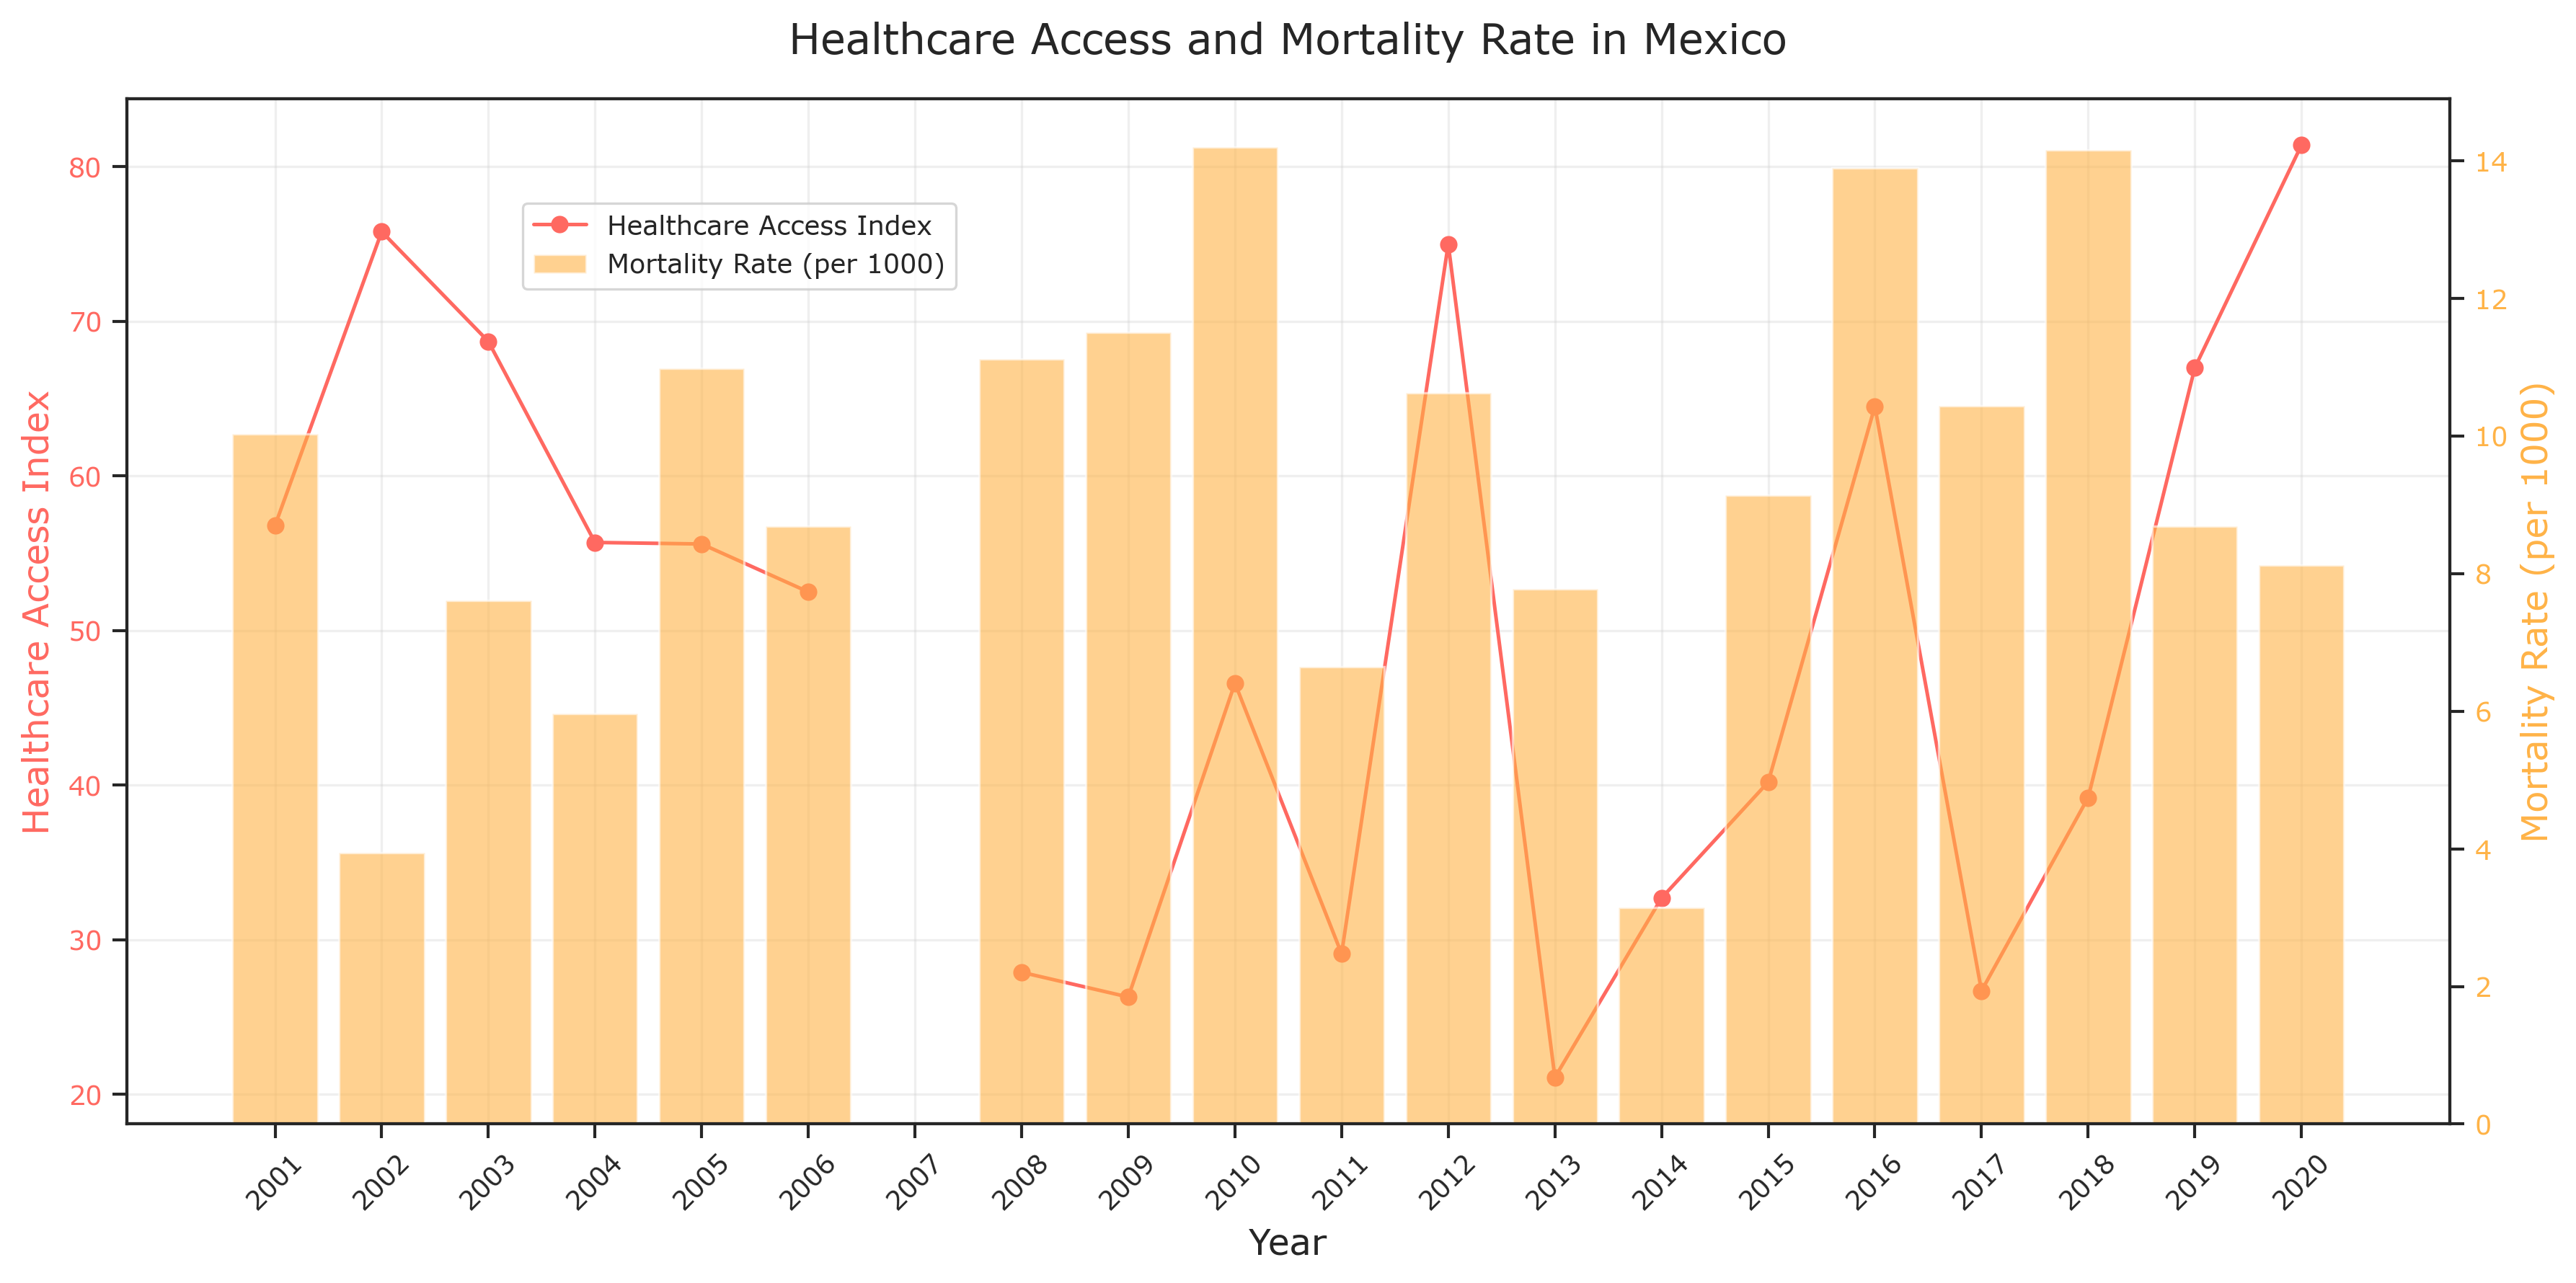

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

file_path = '.../cleandata.csv'
df = pd.read_csv(file_path)

# Set Seaborn theme with custom settings
sns.set_theme(
    style="ticks",
    font="Verdana",  # Font type
    palette=sns.color_palette(["#77dd77", "#ff6961", "#ffb347"]),  # Custom palette
    context="paper"
)

# Set custom Matplotlib parameters
mpl.rcParams["figure.dpi"] = 300  # Set figure DPI for better resolution

# Extract Mexico data
mexico_data = df[df['country'] == 'Mexico'].copy()

# Create a complete year range and merge with existing data
all_years = pd.DataFrame({'year': range(mexico_data['year'].min(), mexico_data['year'].max() + 1)})
mexico_data = pd.merge(all_years, mexico_data, on='year', how='left')

# Visualization variables
mexico_data['year'] = mexico_data['year'].astype(int)
bar_data = mexico_data[mexico_data['year'] != 2007]

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart: Mortality Rate per Thousand
ax2 = ax1.twinx()
ax2.bar(
    bar_data['year'], 
    bar_data['mortality_rate_per_thousand'], 
    color="#ffb347",  # Updated color to green
    alpha=0.6,  # Adjusted alpha for transparency
    label='Mortality Rate (per 1000)'
)
ax2.set_ylabel('Mortality Rate (per 1000)', color="#ffb347", fontsize=12)
ax2.tick_params(axis='y', labelcolor="#ffb347")

# Line chart: Healthcare Access Index (drawn after the bar chart)
ax1.plot(
    mexico_data['year'], 
    mexico_data['healthcare_access_index'], 
    color="#ff6961",  # Updated color to red
    marker='o', 
    label='Healthcare Access Index'
)
ax1.set_ylabel('Healthcare Access Index', color="#ff6961", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#ff6961")
ax1.set_xlabel('Year', fontsize=12)
ax1.set_xticks(mexico_data['year'])
ax1.set_xticklabels(mexico_data['year'], rotation=45)

# Title and legend
fig.suptitle('Healthcare Access and Mortality Rate in Mexico', fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.2, 0.85))
ax1.grid(alpha=0.3)

# Tight layout
fig.tight_layout()
plt.show()


## BAYRAM KAAN YILMAZ

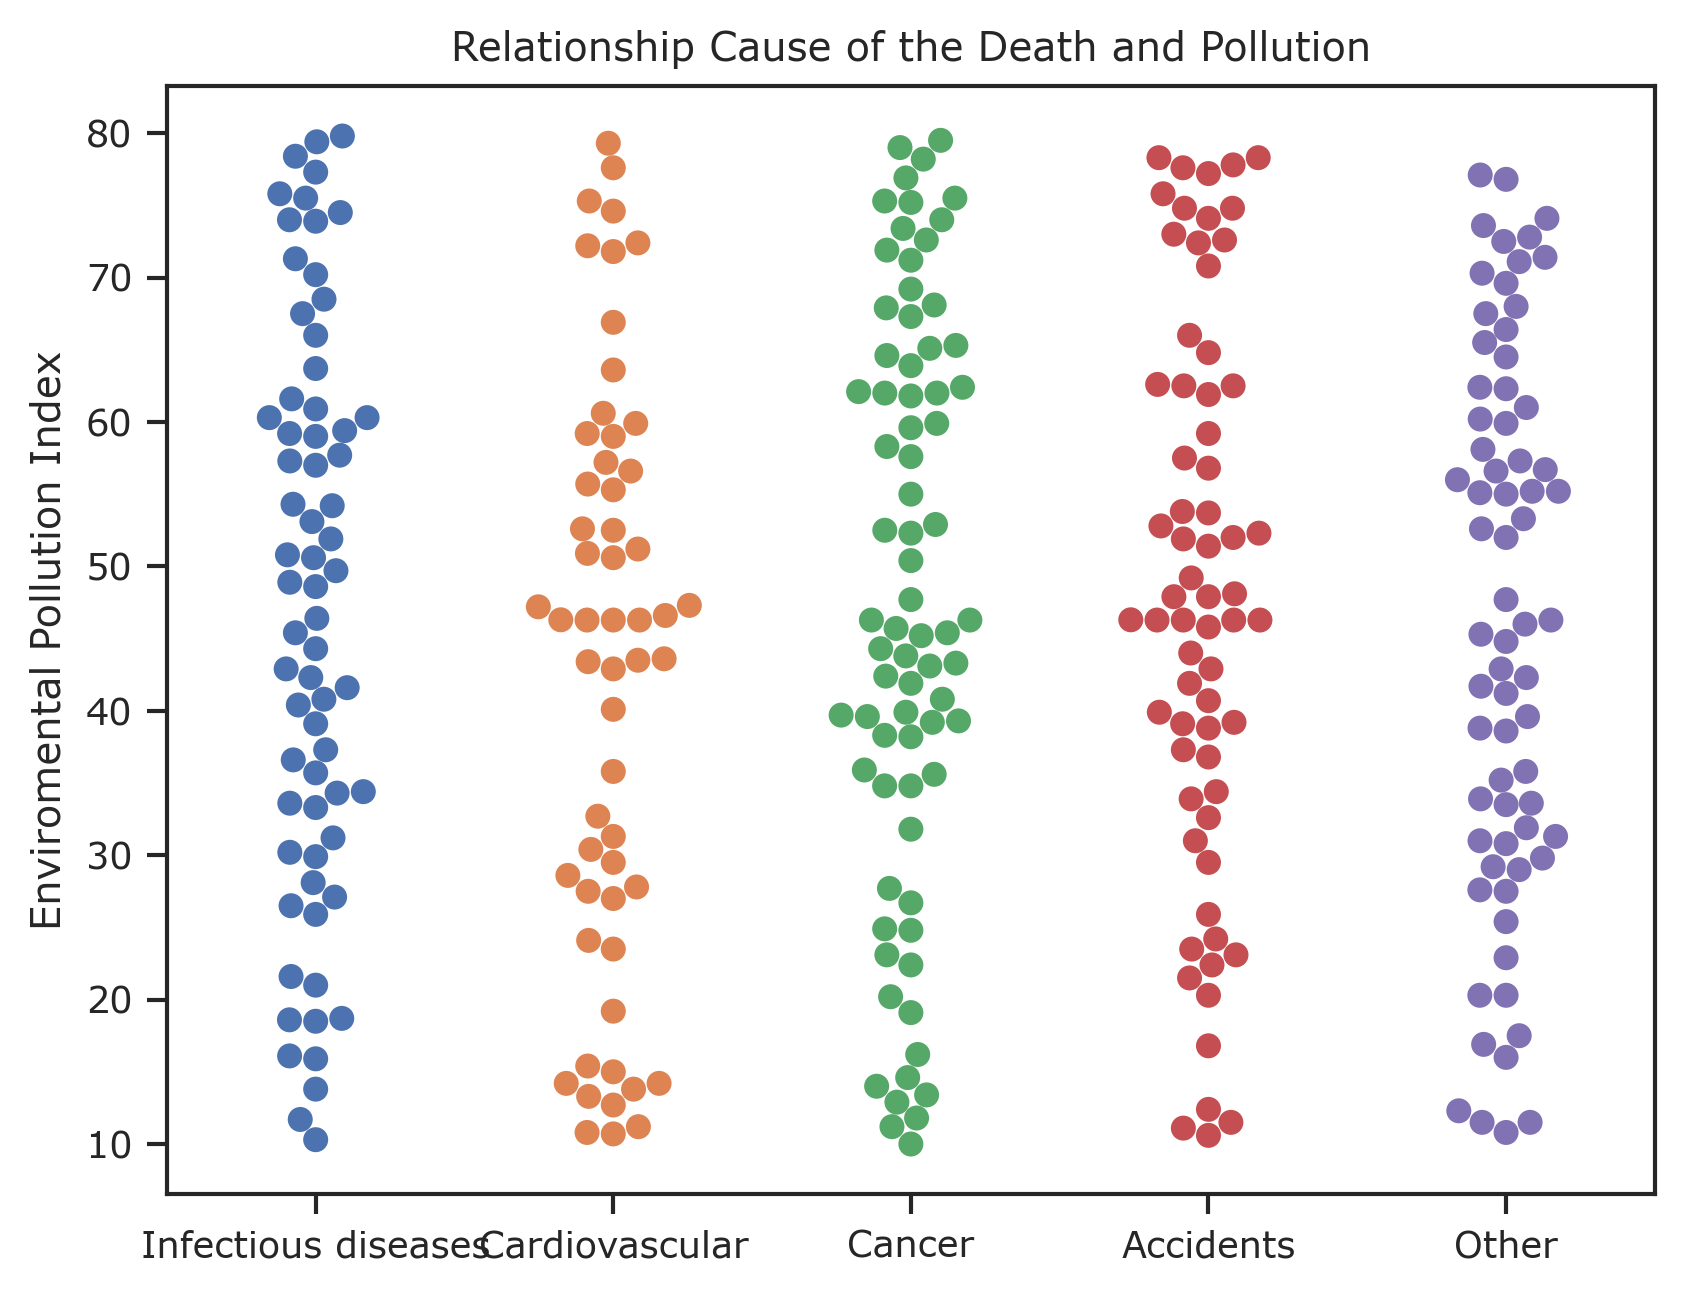

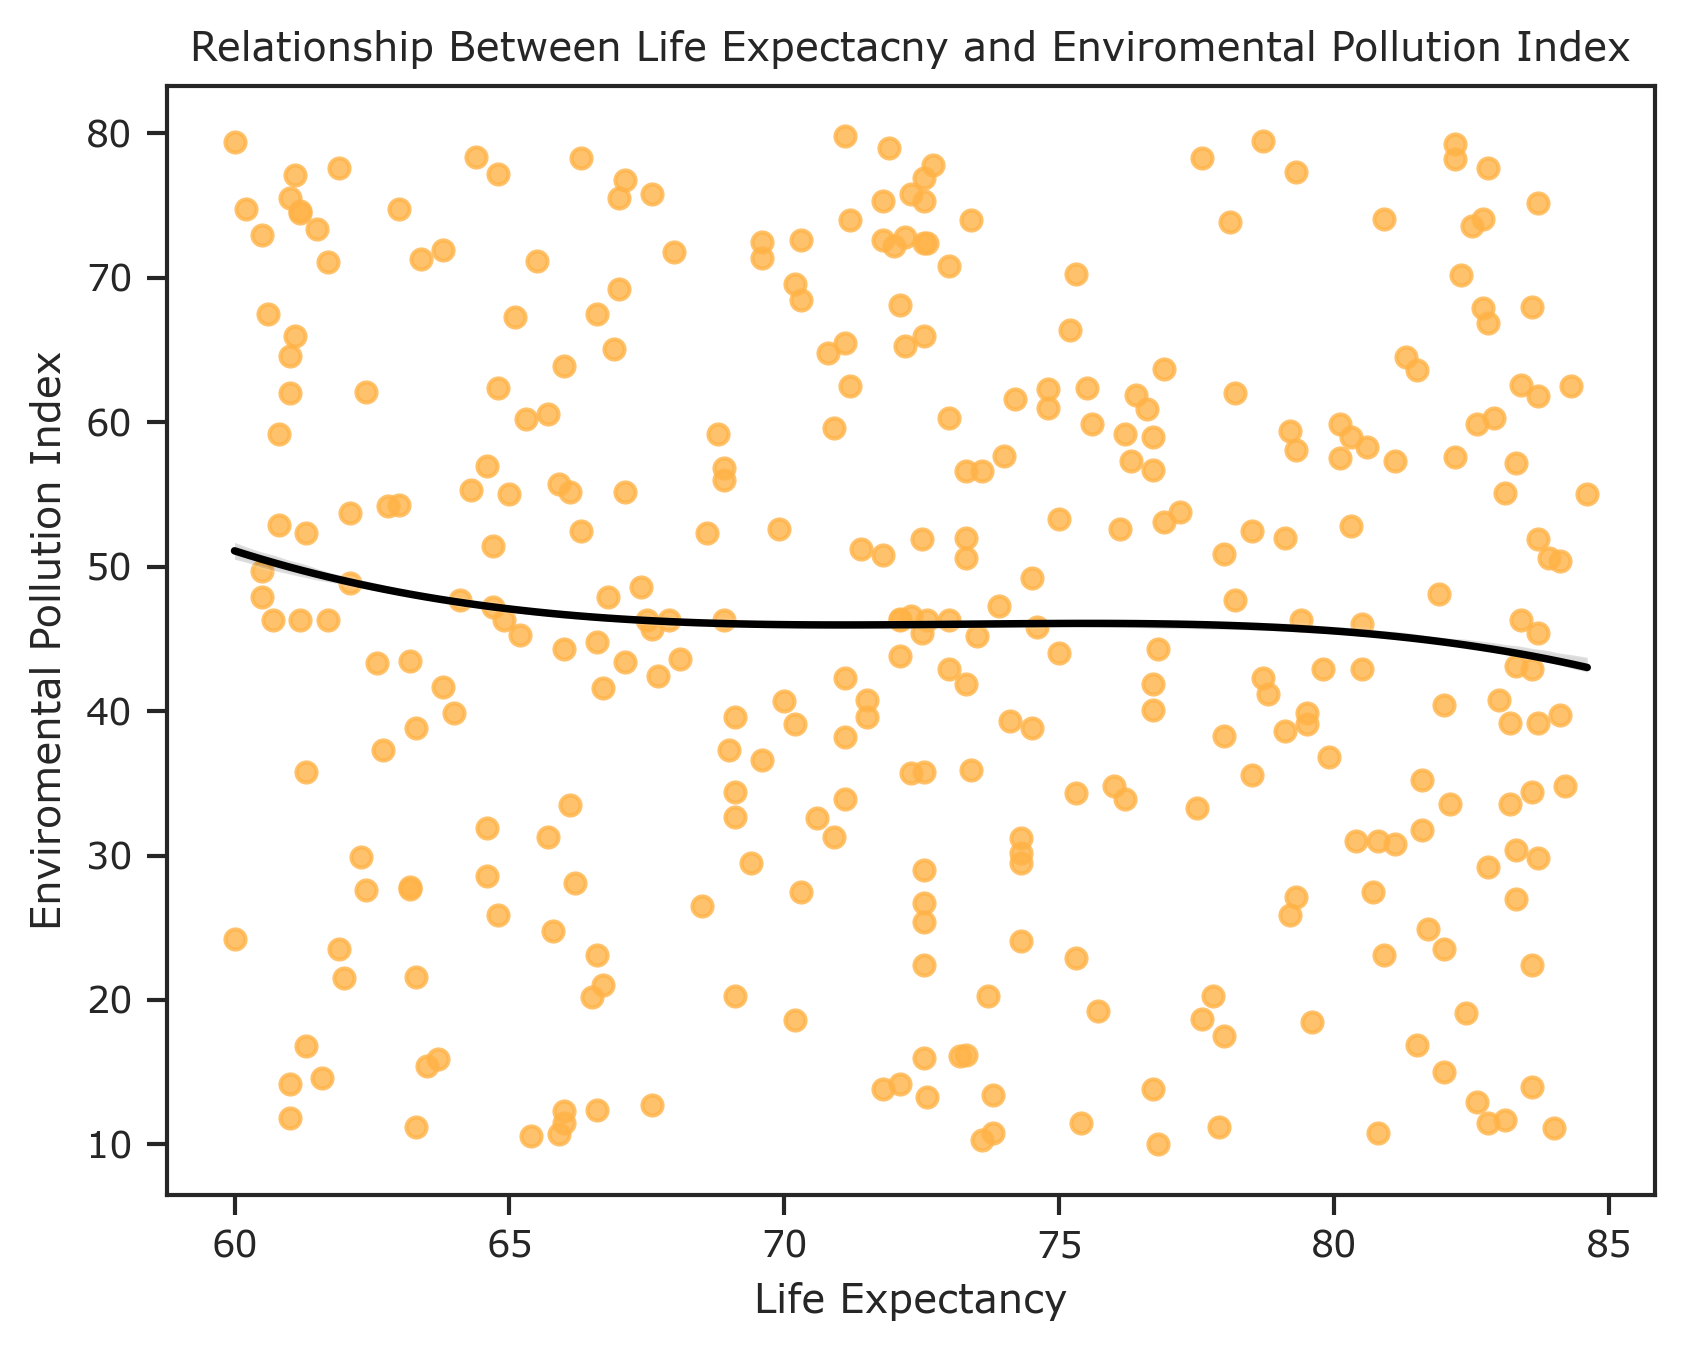

In [49]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#opening and reading cleaned data file as csv 
data = open(".../cleandata.csv")
df = pd.read_csv(data)
#writing palette and other factors to set theme
sns.set_theme(
    style="ticks",
    font="Verdana",
    palette=sns.color_palette(["#ffb347", "#77dd77", "#ff6961"]),
    context="paper",
)
#creating swarmplot to visualize distribution and relationship
swarmplot = sns.swarmplot(data=df, x="cause_of_death", y="environmental_pollution_index", hue="cause_of_death", legend=False, palette="deep", size= 6)
#writing title, fixing label
swarmplot.set_title("Relationship Cause of the Death and Pollution")
swarmplot.set(xlabel ="", ylabel= "Enviromental Pollution Index")
plt.show()

#creating swarmplot to visualize distribution and relationship
regplot = sns.regplot(data=df, x='life_expectancy', y='environmental_pollution_index', order=3, line_kws=dict(color="black"), ci=10)
#writing title, fixing label and selecting styles
regplot.set_title("Relationship Between Life Expectacny and Enviromental Pollution Index")
regplot.set(xlabel="Life Expectancy", ylabel="Enviromental Pollution Index")

plt.show()


## CİHAN CANIMOĞLU

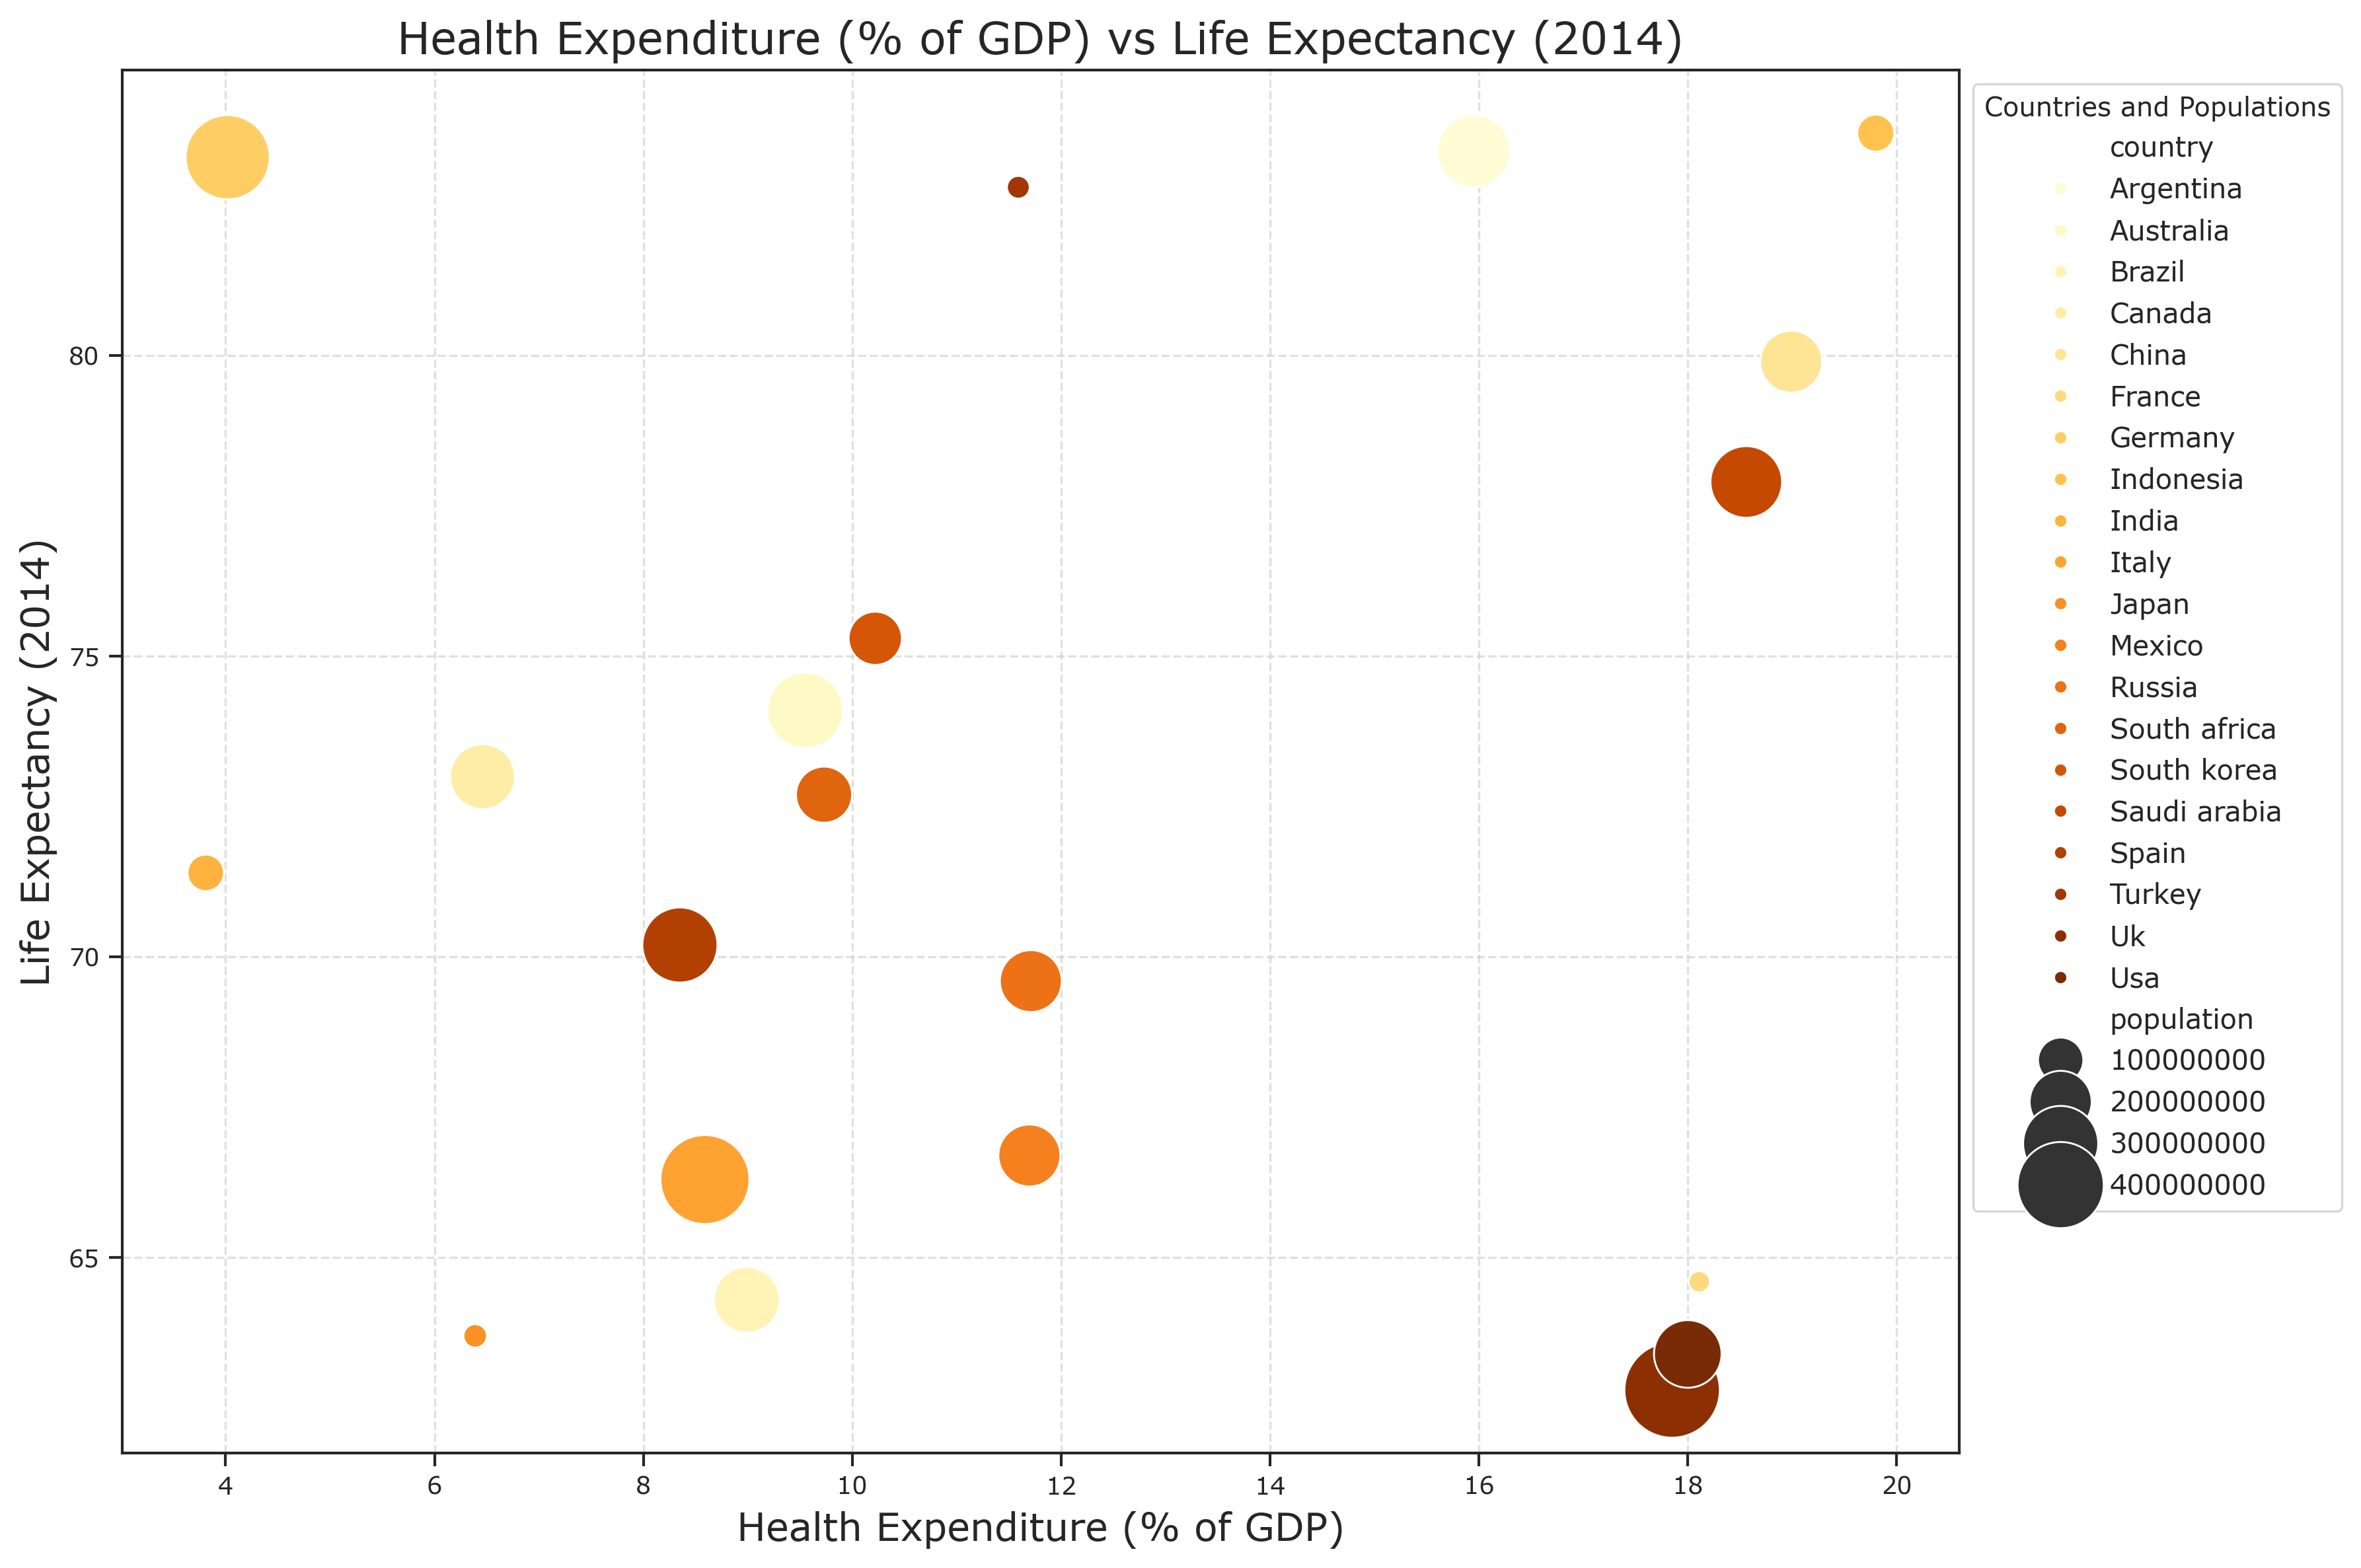

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = ".../cleandata.csv"  
df_clean = pd.read_csv(file_path)  

data_2014 = df_clean[df_clean["year"] == 2014]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data_2014,
    x="health_expenditure_gdp",
    y="life_expectancy",
    size="population", 
    sizes=(60, 1200), 
    alpha=1,
    hue="country",
    palette='YlOrBr'
)

plt.title('Health Expenditure (% of GDP) vs Life Expectancy (2014)', fontsize=16)
plt.xlabel('Health Expenditure (% of GDP)', fontsize=14)
plt.ylabel("Life Expectancy (2014)", fontsize=14)
plt.legend(title='Countries and Populations', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## METE KOÇOĞLU

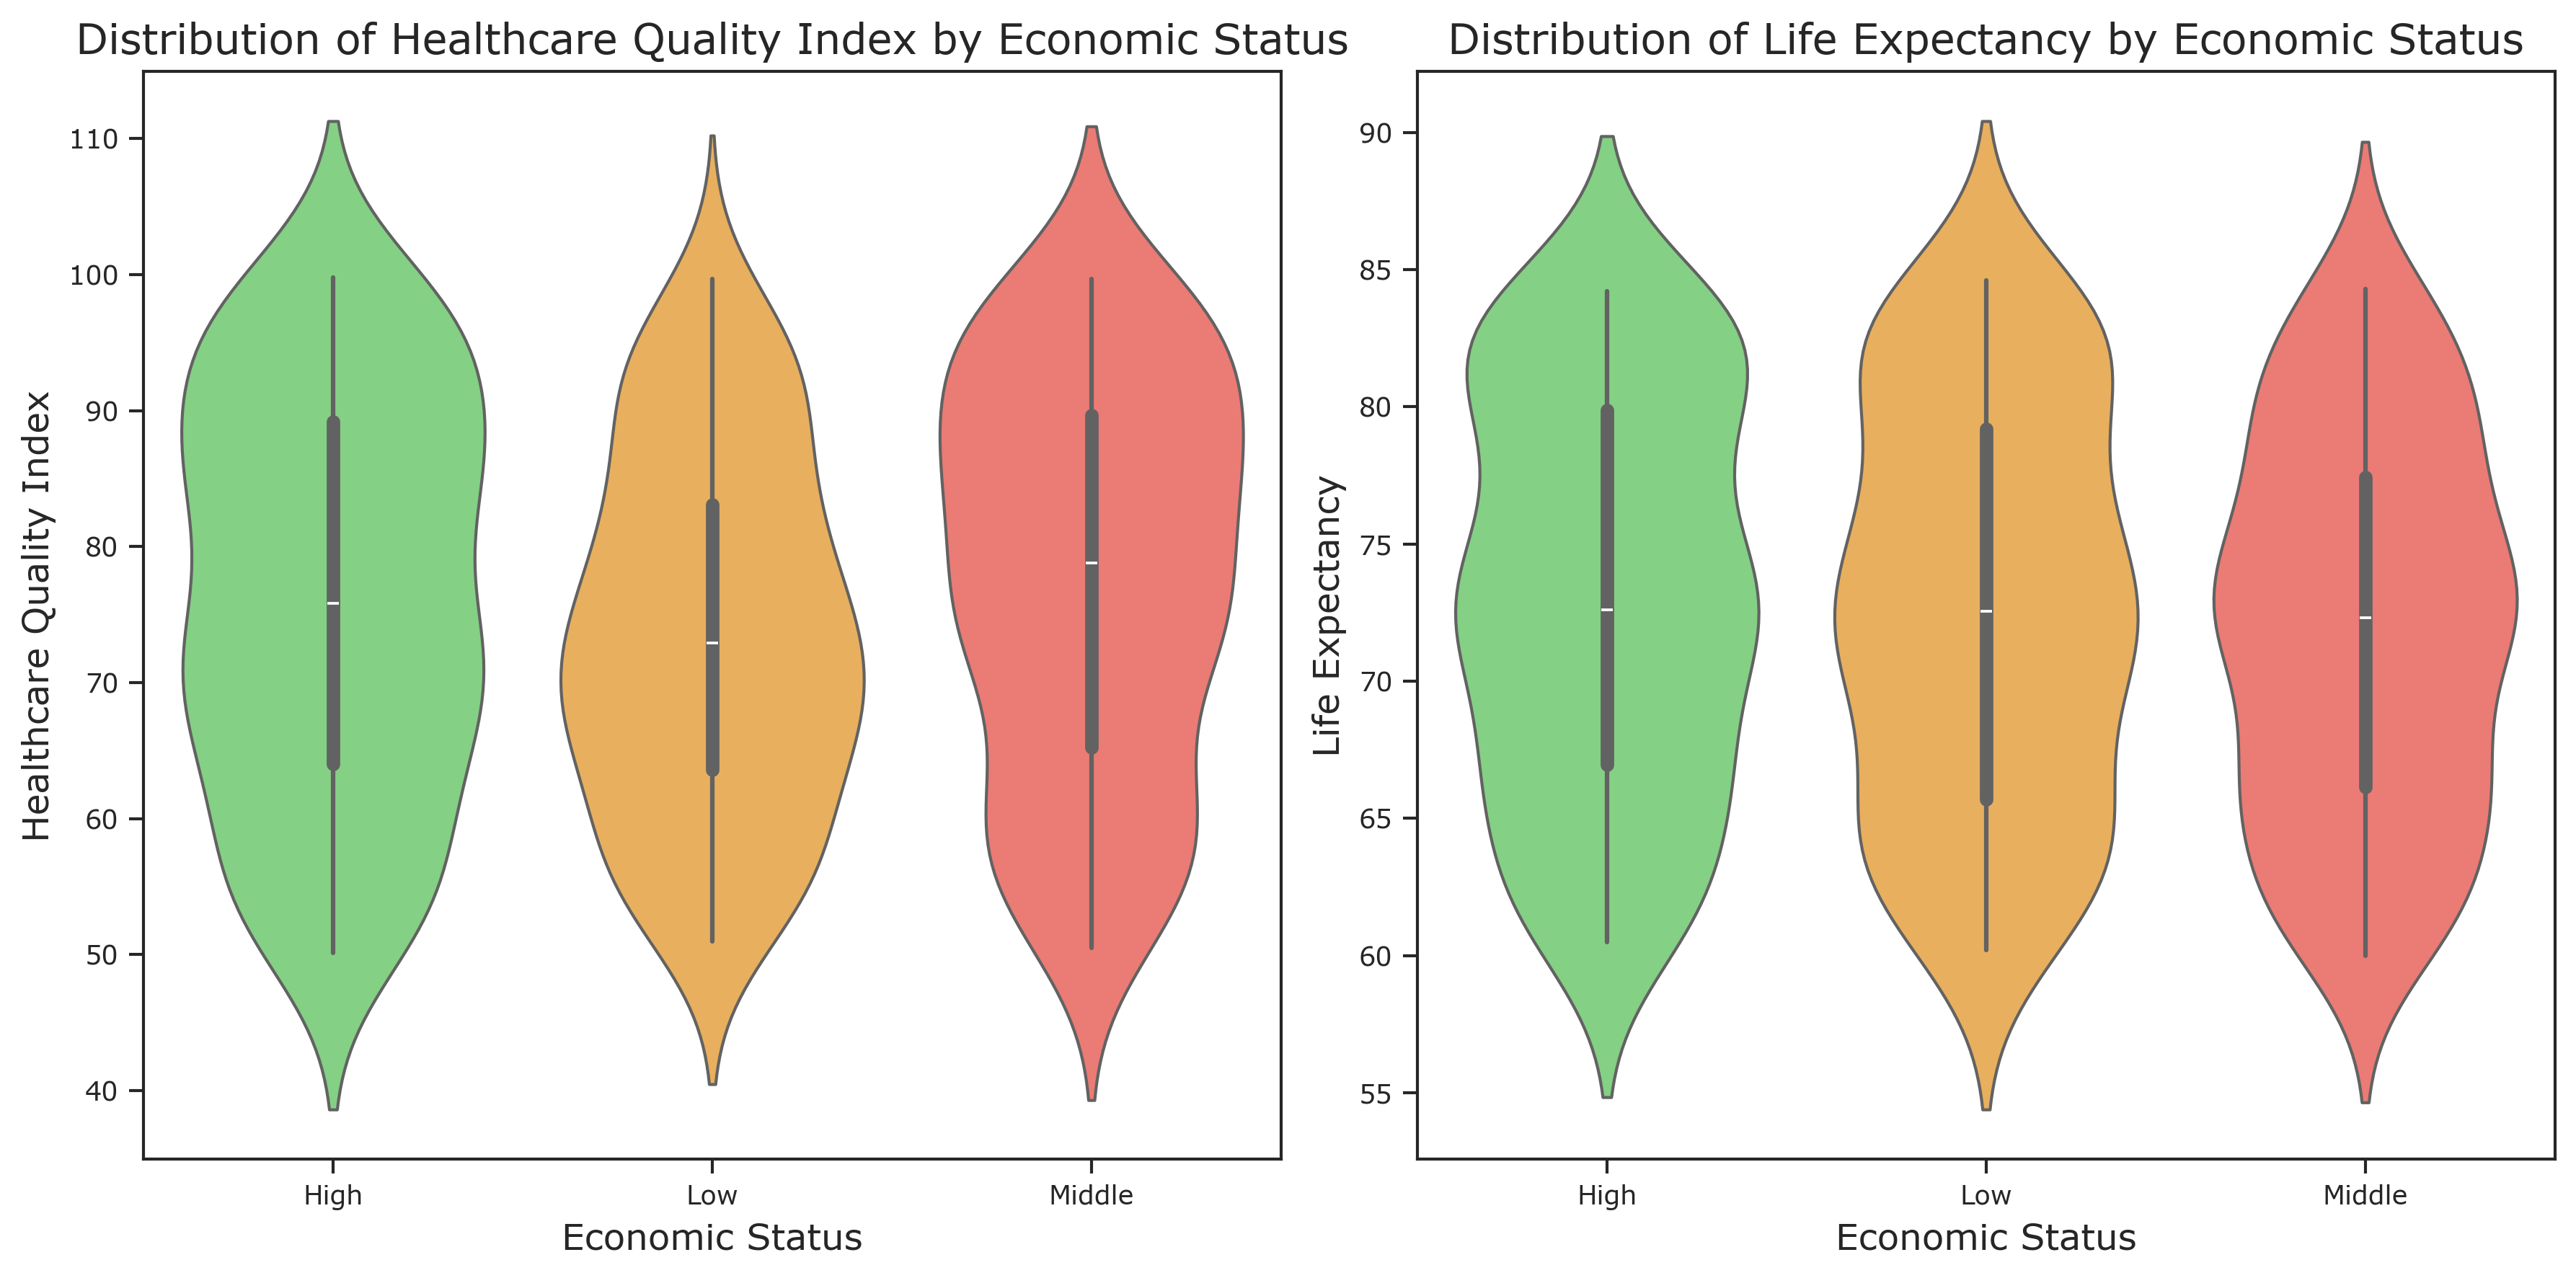

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
file_path = "celannnn.csv"  
df_cleaned = pd.read_csv(file_path)

# Create a violin plot to show the distribution of Healthcare Quality Index and Life Expectancy across different Economic Status
plt.figure(figsize=(12, 6))

# Define a custom color palette
custom_palette = ["#77dd77", "#ffb347", "#ff6961"]

# Violin plot for Healthcare Quality Index by Economic Status
plt.subplot(1, 2, 1)  # First plot in a 1x2 grid
sns.violinplot(
    data=df_cleaned,
    x='economic_status',
    y='healthcare_quality_index',
    hue='economic_status',  # Set the hue to the same as x
    palette=custom_palette,
    dodge=False,  # Avoid splitting by hue
    legend=False  # Suppress legend
)
plt.title('Distribution of Healthcare Quality Index by Economic Status', fontsize=14)
plt.xlabel('Economic Status', fontsize=12)
plt.ylabel('Healthcare Quality Index', fontsize=12)

# Violin plot for Life Expectancy by Economic Status
plt.subplot(1, 2, 2)  # Second plot in a 1x2 grid
sns.violinplot(
    data=df_cleaned,
    x='economic_status',
    y='life_expectancy',
    hue='economic_status',  # Set the hue to the same as x
    palette=custom_palette,
    dodge=False,  # Avoid splitting by hue
    legend=False,  # Suppress legend
)
plt.title('Distribution of Life Expectancy by Economic Status', fontsize=14)
plt.xlabel('Economic Status', fontsize=12)
plt.ylabel('Life Expectancy', fontsize=12)

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


## LARA KAYAALP

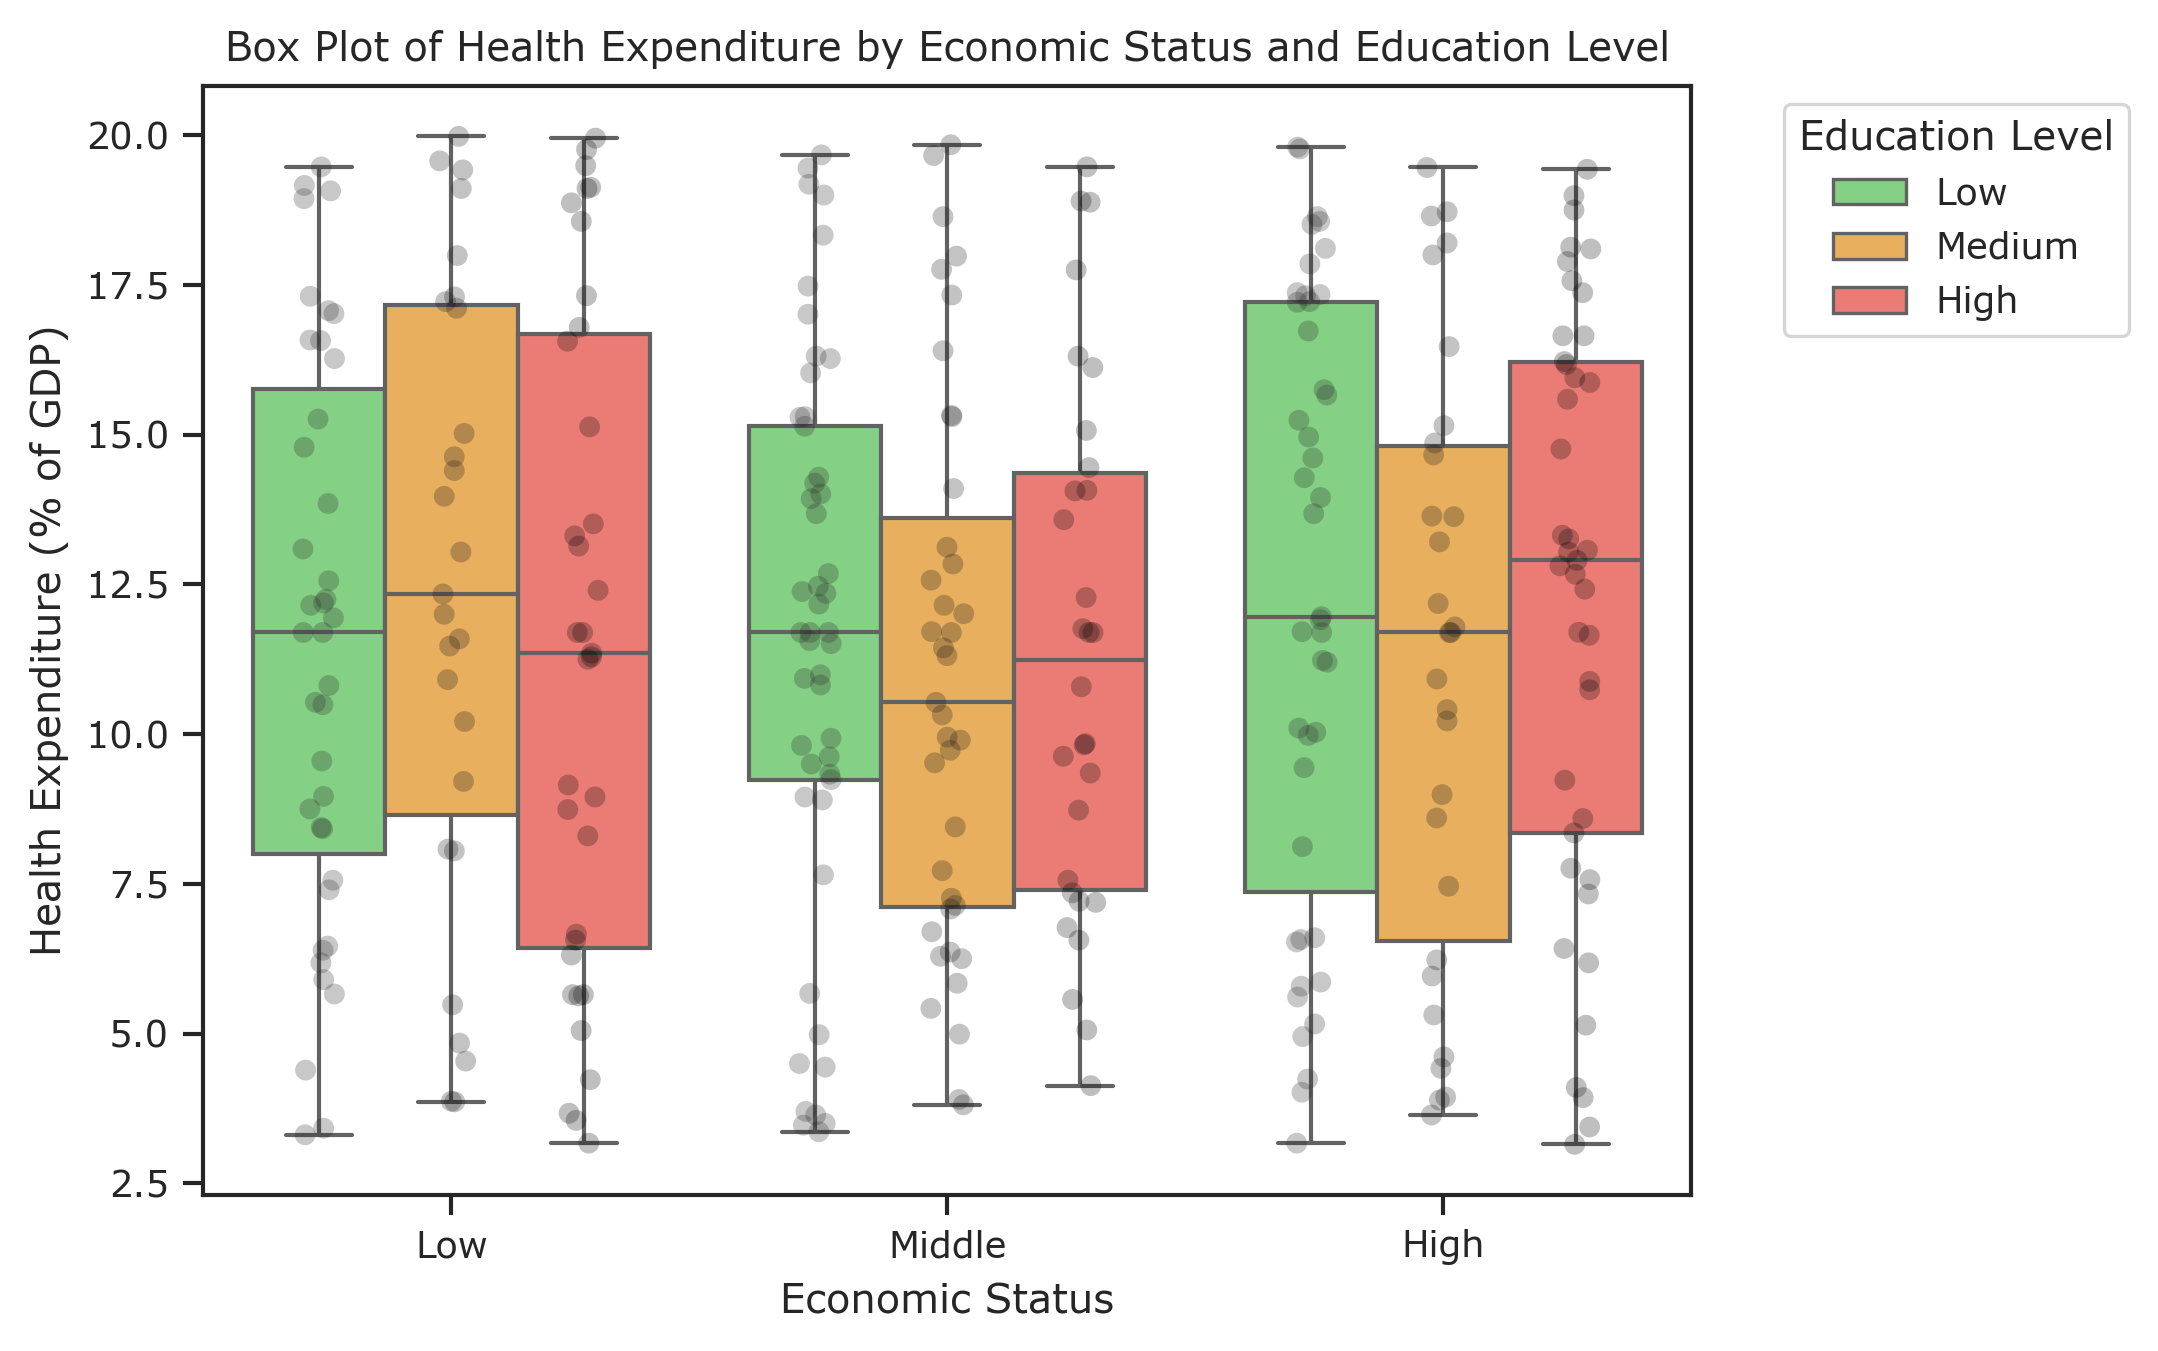

In [57]:
#The following code:

#1. Imports the necessary libraries; `matplotlib`, `pandas` and `seaborn`.
#2. Sets the theme with style `ticks`; font `Verdana`; palette of pastel green, yellow, and red; and context `paper`.
#3. Sets the figure size to 300 DPI for larger resolution outputs.
#4. Loads the clean dataset.

import matplotlib as mpl
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(
    style="ticks",
    font="Verdana",
    palette=sns.color_palette(["#77dd77", "#ffb347", "#ff6961"]),
    context="paper",
)

mpl.rcParams["figure.dpi"] = 300

df = pd.read_csv(".../cleandata.csv")

#The following code:

#1. Sets title and labels.
#2. Creates the box plot with economic status at X-axis, education level at hue and health expenditure at Y-axis.
#3. Creates the swarm plot with the same dimensions to be overlayed on the box plot, so that individual data points are visible.
#4. Hides redundant swarm plot hue descriptions from the legend.
#5. Displays the plot.


plt.title("Box Plot of Health Expenditure by Economic Status and Education Level")
plt.xlabel("Economic Status")
plt.ylabel("Health Expenditure (% of GDP)")

sns.boxplot(
    x="economic_status",
    y="health_expenditure_gdp",
    hue="education_level",
    data=df,
    order=["Low", "Middle", "High"],
    hue_order=["Low", "Medium", "High"],
)

sns.stripplot(
    x="economic_status",
    y="health_expenditure_gdp",
    hue="education_level",
    data=df,
    order=["Low", "Middle", "High"],
    hue_order=["Low", "Medium", "High"],
    dodge=True,
    jitter=True,
    marker="o",
    alpha=0.25,
    palette="dark:k",
)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:3],
    labels[:3],
    title="Education Level",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

plt.show()

## ŞEYMA KARABULUT

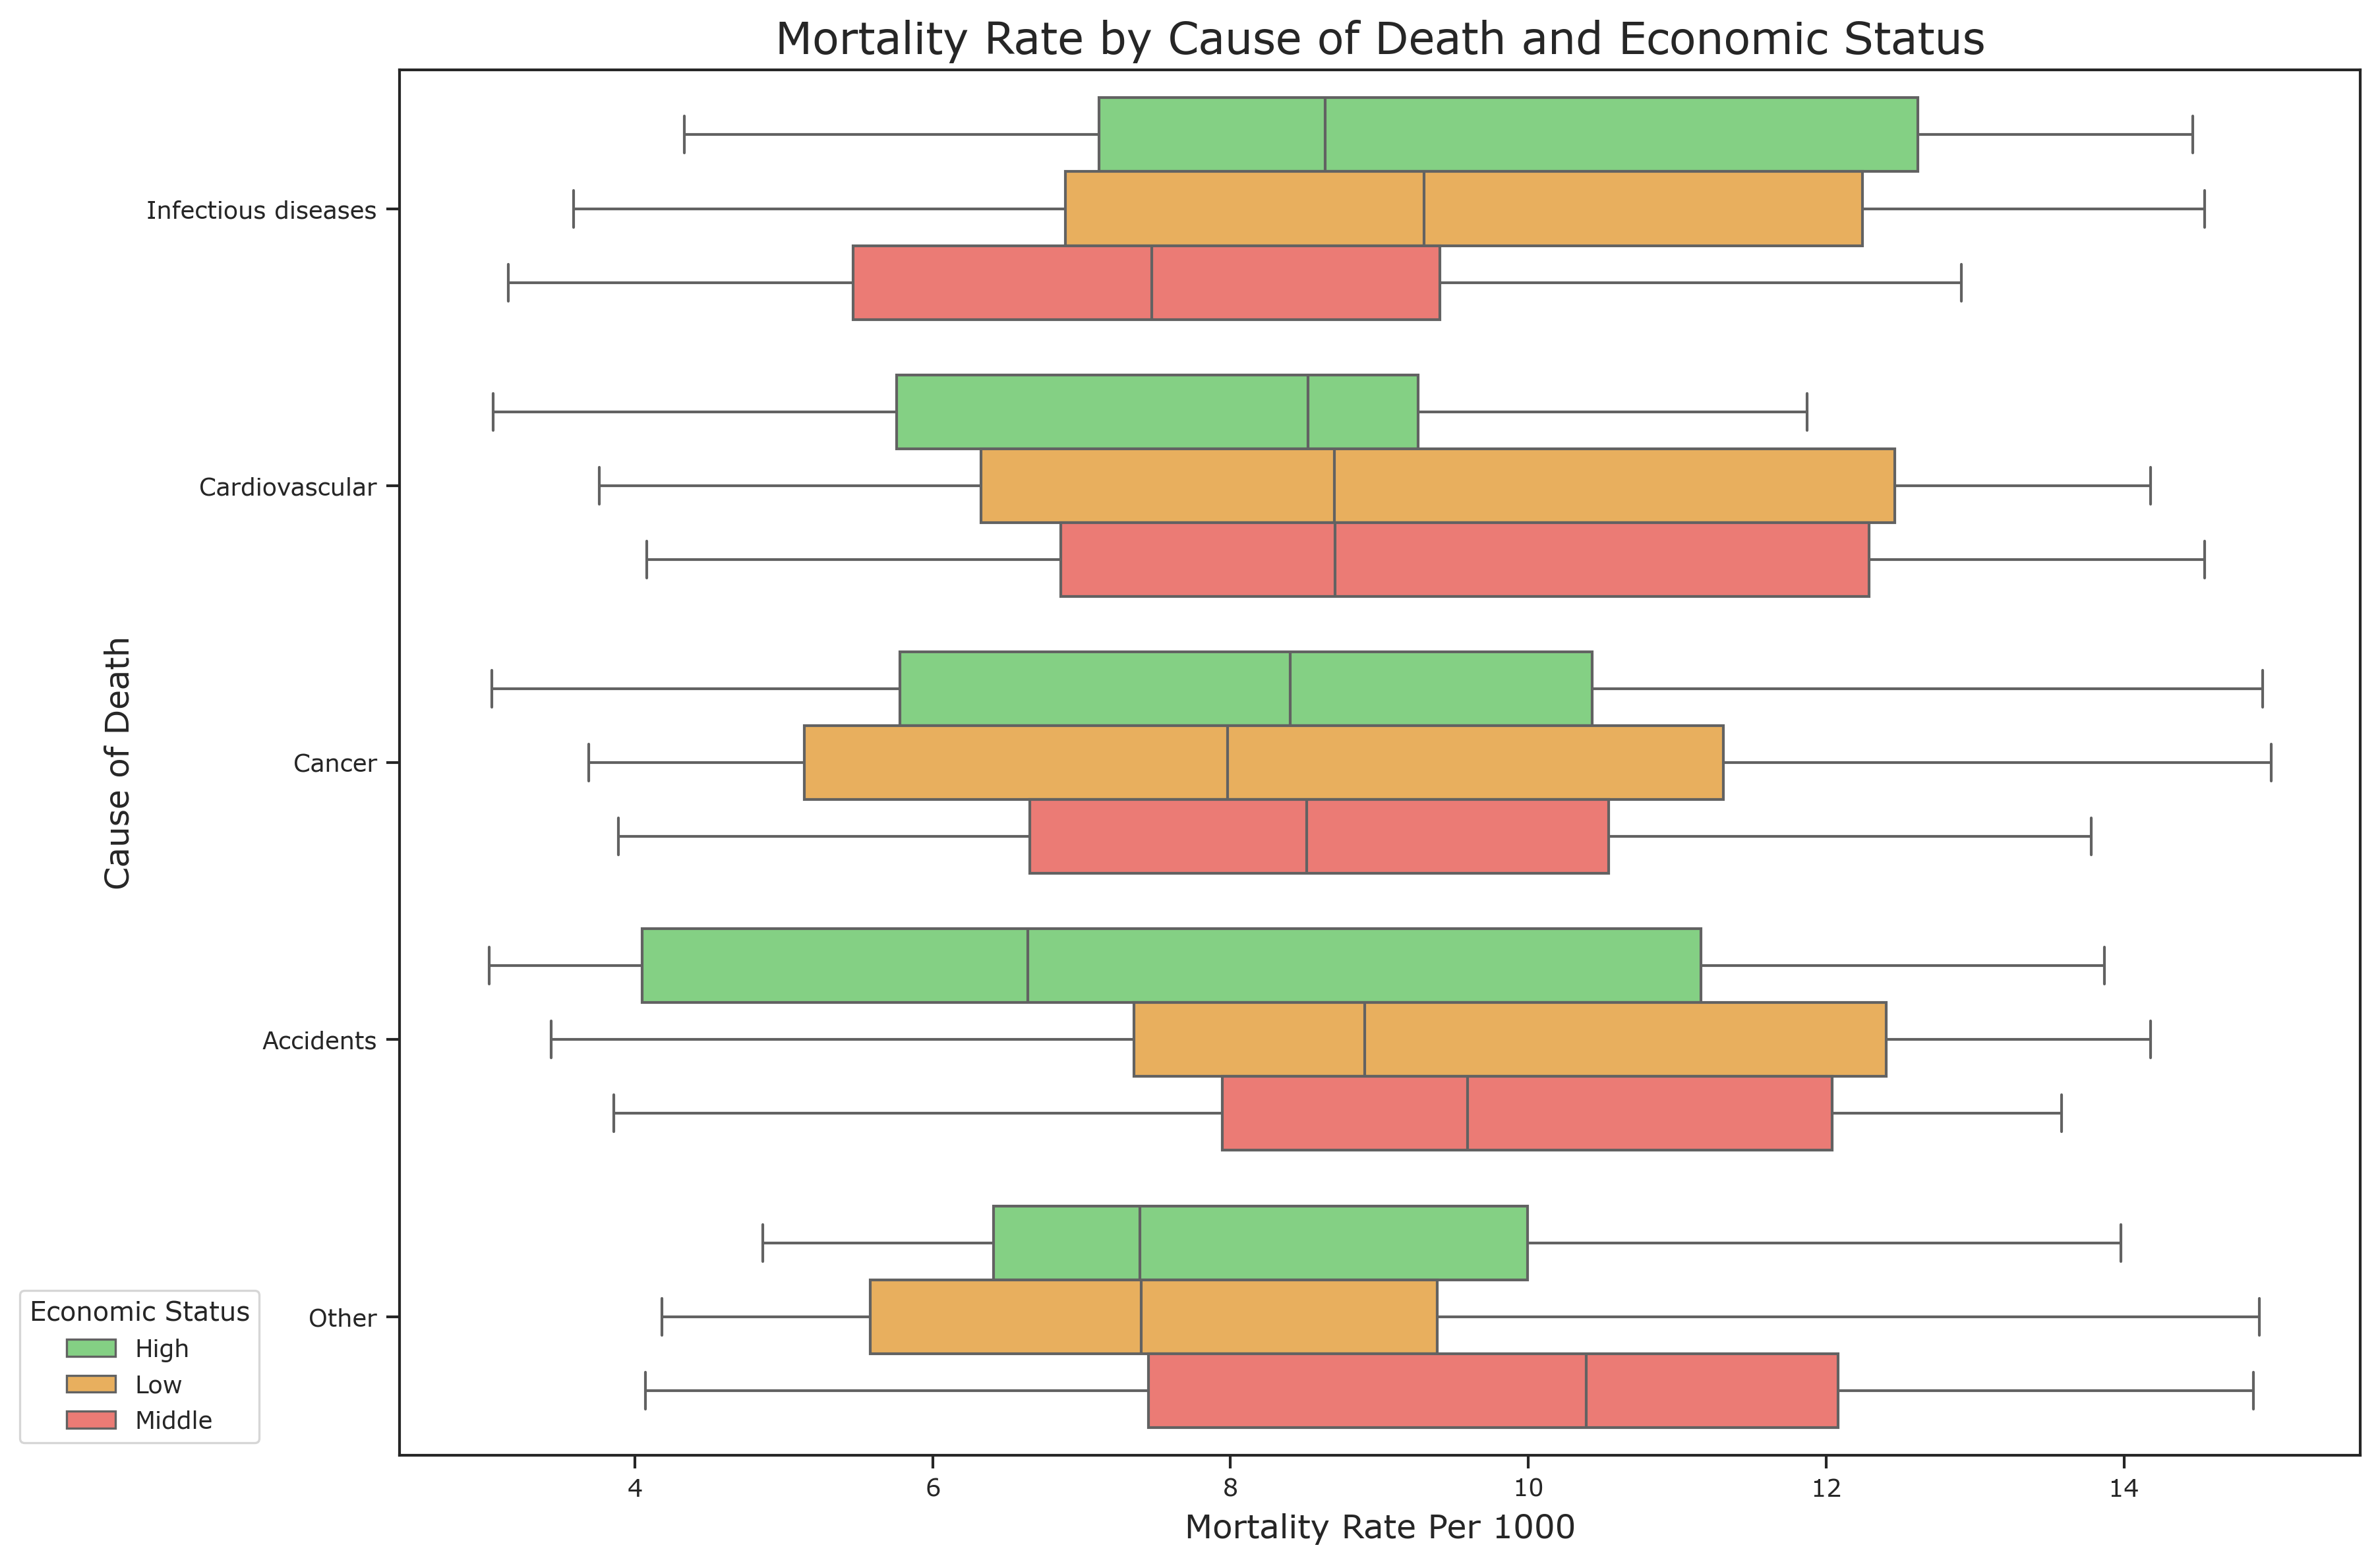

In [59]:
#importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Setting the theme of the graph
sns.set_theme(
    style="ticks",
    font="Verdana",
    palette=sns.color_palette(["#77dd77", "#ffb347", "#ff6961"]),
    context="paper",
)

# Loading the previously cleaned dateset
file_path = ".../cleandata.csv"  
df_cleaned = pd.read_csv(file_path)  

#The code of the boxplots that displays the relationships between Mortality Rate Per 1000, Cause of Death and Economic Status
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_cleaned,
    x="mortality_rate_per_thousand",
    y="cause_of_death",
    hue="economic_status",

)

# Determining the title and axis names
plt.title("Mortality Rate by Cause of Death and Economic Status", fontsize=16)
plt.xlabel("Mortality Rate Per 1000", fontsize=12)
plt.ylabel("Cause of Death", fontsize=12)

# Creating a legend
plt.legend(
    title="Economic Status",
    loc="lower left",
    bbox_to_anchor=(-0.2, 0)  # Adjust x and y values as needed
)

# Displaying the plot
plt.tight_layout()
plt.show()